In [6]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation
import imageio.v2 as imageio

In [204]:
def getProb(vec):
    return np.array(list(map(float, np.exp(vec)/np.sum(np.exp(vec)))))

In [205]:
class Sender:
        
    def __init__(self, inputs_n: int, messages_n_m: (int, int), eps: float = 1e-6):
        self.messages = messages_n_m
        self.message_weights = (np.zeros((inputs_n, messages_n_m[0]), dtype=np.float128), np.zeros((inputs_n, messages_n_m[1]), dtype=np.float128))
        self.message_weights[0].fill(eps)
        self.message_weights[1].fill(eps)
        self.channel_weights = np.zeros(2, dtype=np.float128)
        self.channel_weights.fill(np.float128(eps))
        self.last_situation = (0, 0, (0, 0)) # urn, input, message, 
        
    def send_message(self, input: int) -> (int, int):
        # get a channel to manipulate
        channel_probs = getProb(self.channel_weights)
        channel = np.random.choice([0, 1], p=channel_probs)
        
        if channel == 0:
            # manipulate channel 0, the other is picked at random
            probs = getProb(self.message_weights[0][input, :])
            message = (np.random.choice(self.messages[0], p=probs), np.random.choice(self.messages[1]))
        else:
            # manipulate channel 0, the other is picked at random
            probs = getProb(self.message_weights[1][input, :])
            message = (np.random.choice(self.messages[0]), np.random.choice(self.messages[1], p=probs))
       
        self.last_situation = (channel, input, message)
        return message

    def learn_from_feedback(self, reward: float) -> None:
        last_channel = self.last_situation[0]
        self.channel_weights[last_channel] += np.float128(reward)/10
        self.message_weights[last_channel][(self.last_situation[1], self.last_situation[2][last_channel])] += np.float128(reward)


In [206]:
class Receiver:
        
    def __init__(self, n_messages: int, m_messages: int, n_actions: int, eps: float = 1e-6):
        self.n_actions = n_actions
        self.action_weights = (np.ndarray((n_messages, n_actions), dtype=np.float128), np.ndarray((m_messages, n_actions), dtype=np.float128))
        self.channel_weights  = np.zeros(2)
        self.action_weights[0].fill(np.float128(eps))
        self.action_weights[1].fill(np.float128(eps))
        self.channel_weights.fill(np.float128(eps))
        self.last_situation = (0, (0, 0), 0)
        
    def act(self, message: (int, int)) -> int:
        # get channel to pay attention to
        channel_probs = getProb(self.channel_weights)
        channel = np.random.choice([0, 1], p=channel_probs)

        # pick action from focused channel
        probs = getProb(self.action_weights[channel][message[channel], :])
        action = np.random.choice(self.n_actions, p=probs)
            
        self.last_situation = (channel, message, action)
        return action

    def learn_from_feedback(self, reward: float) -> None:
        last_channel = self.last_situation[0]
        self.channel_weights[last_channel] += np.float128(reward)/10    
        self.action_weights[last_channel][(self.last_situation[1][last_channel], self.last_situation[2])] += np.float128(reward)

In [195]:
class World:
    def __init__(self, n_states: int, seed: int = 1701):
        self.n_states = n_states
        self.state = 0
        self.rng = np.random.RandomState(seed)
        
    def emit_state(self) -> int:
        self.state = self.rng.randint(self.n_states)
        return self.state
    
    def evaluate_action(self, action: int) -> float:
        return 1 if action == self.state else 0

In [207]:
class Run:
    def __init__(self):
        self.generations = 3000
        self.sender_convergence = []
        self.receiver_convergence = []
        self.num_inputs = 3
        self.channel_0 = 3
        self.channel_1 = 2
        self.sender = Sender(self.num_inputs, (self.channel_0, self.channel_1))
        self.receiver = Receiver(self.channel_0, self.channel_1, self.num_inputs)
        self.world = World(self.num_inputs)
        
    def simulate(self):
        for epoch in range(self.generations):
            world_state = self.world.emit_state()
            message = self.sender.send_message(world_state)
            action = self.receiver.act(message)
            reward = self.world.evaluate_action(action)
            self.receiver.learn_from_feedback(reward)
            self.sender.learn_from_feedback(reward)
            sw = getProb(self.sender.channel_weights)
            rw = getProb(self.receiver.channel_weights)
            self.sender_convergence.append(sw[0])
            self.receiver_convergence.append(rw[0])

    def get_channel_fitness(self, channel):
        return (np.apply_along_axis(getProb, 1, self.sender.message_weights[channel]) * np.apply_along_axis(getProb, 1, self.receiver.action_weights[channel]).T).sum() / self.num_inputs

    def get_fitness(self):
        s_channel_prob = getProb(self.sender.channel_weights)
        r_channel_prob = getProb(self.receiver.channel_weights)
        channel_0_fitness = self.get_channel_fitness(0)
        channel_1_fitness = self.get_channel_fitness(1)
        return s_channel_prob[0] * r_channel_prob[0] * channel_0_fitness + s_channel_prob[1] * r_channel_prob[1] * channel_1_fitness
    
    def heatmap(self):
        for channel in range(2):
            plt.tight_layout(pad=0)
            plot = sns.heatmap(
                np.exp(self.receiver.action_weights[channel])/np.exp(self.receiver.action_weights[channel]).sum(axis=0), 
                square=True, cbar=False, annot=True, fmt='.1f'
            ).get_figure()
            plt.xlabel('messages')
            plt.ylabel('actions')
            plt.title(f'Receiver\'s weights on channel {channel}, rollout')
            plt.show()
            plt.clf()
    
            plot = sns.heatmap(
                np.exp(self.sender.message_weights[channel])/np.exp(self.sender.message_weights[channel]).sum(axis=0), 
                square=True, cbar=False, annot=True, fmt='.1f'
            ).get_figure()
            plt.xlabel('inputs')
            plt.ylabel('messages')
            plt.title(f'Senders\'s weights on channel {channel}, rollout')
            plt.show()
            plt.clf()
    
    def plot(self):
        t = np.arange(0, self.generations)
        fig, axs = plt.subplots(2, 1, layout='constrained')
        axs[0].plot(t, self.sender_convergence)
        axs[1].plot(t, self.receiver_convergence)
        axs[0].set_ylim(0, 1)
        axs[1].set_ylim(0, 1)
        axs[0].set_xlabel('Generations')
        axs[1].set_xlabel('Generations')
        axs[0].set_ylabel('sender convergence')
        axs[1].set_ylabel('receiver convergence')
        axs[0].grid(True)
        axs[1].grid(True)
        
        plt.show()
        

channel 0 fitness 1.0
channel 1 fitness 0.5451392130931519
fitness 1.0


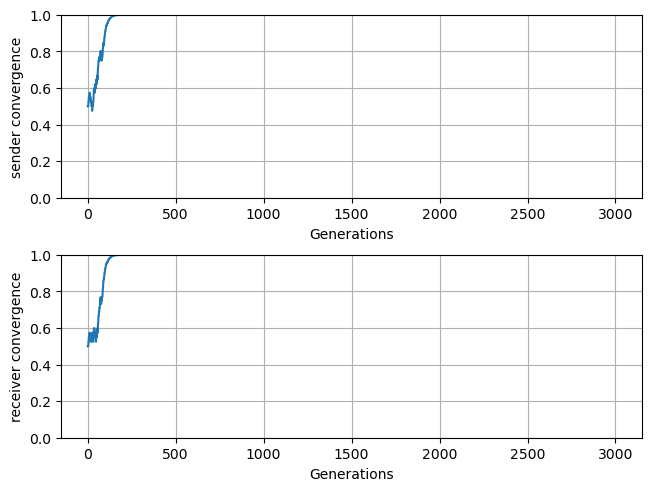

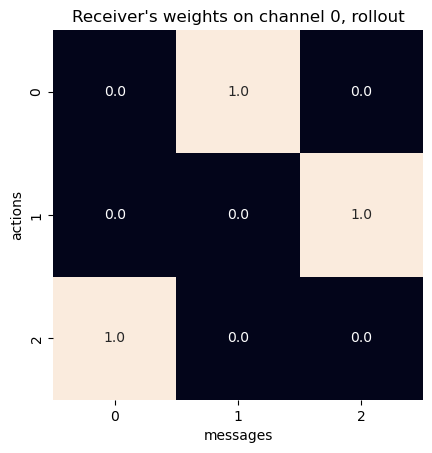

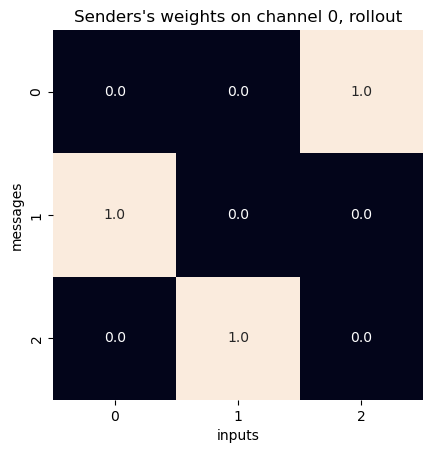

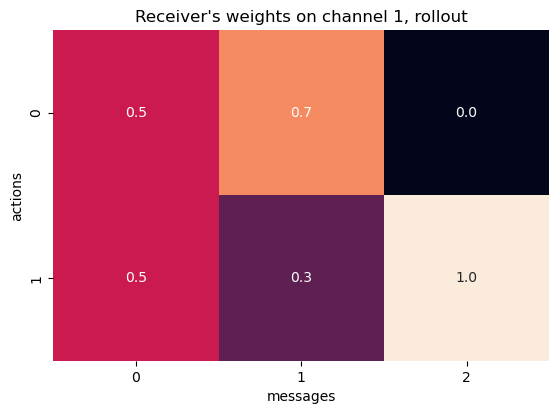

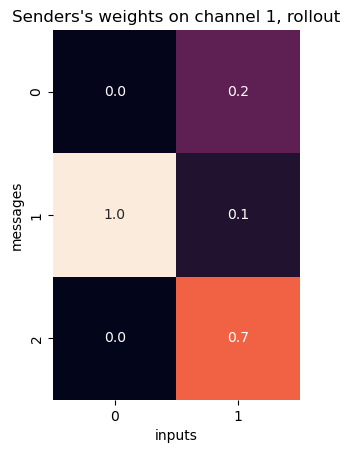

<Figure size 640x480 with 0 Axes>

In [208]:
run = Run()
run.simulate()

print("channel 0 fitness", run.get_channel_fitness(0))
print("channel 1 fitness", run.get_channel_fitness(1))
print("fitness", run.get_fitness())

run.plot()
run.heatmap()

In [ ]:
sender_optimum = 0
receiver_optimum = 0
converge = 0
for i in range(100):
    if i % 10 == 0:
        print(i)
    run = Run()
    run.simulate()
    #run.plot()
    run.sender.channel_weights[0] > run.sender.channel_weights[1]
    is_sender_optimum = run.sender.channel_weights[0] > run.sender.channel_weights[1]
    is_receiver_optimum = run.receiver.channel_weights[0] > run.receiver.channel_weights[1]
    if is_sender_optimum:
        sender_optimum += 1
    if is_receiver_optimum:
        receiver_optimum += 1
    if (is_sender_optimum and is_receiver_optimum) or ((not is_sender_optimum) and (not is_receiver_optimum)):
        converge += 1
        
print("sender ends up in optimum", sender_optimum)
print("receiver ends up in optimum", receiver_optimum)
print("both converge", converge)

0
10
20
30
40
50
